# Imports and configs

In [1]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from scipy.special import logit
from scipy.linalg._misc import LinAlgWarning
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import pickle
import glob
import json
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e10/train.csv'
    test_path = '/kaggle/input/playground-series-s4e10/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e10/sample_submission.csv'
    
    oof_path = '/kaggle/input/loan-approval-prediction-oof-files'
    
    target = 'loan_status'
    n_folds = 10
    seed = 42
    
    tune = False

# Loading OOF Files

In [3]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]

In [4]:
def get_data(path):
    oof_pred_probs_files = glob.glob(f'{path}/*_oof_pred_probs_*.pkl')
    test_pred_probs_files = glob.glob(f'{path}/*_test_pred_probs_*.pkl')

    oof_pred_probs = pickle.load(open(oof_pred_probs_files[0], 'rb'))
    test_pred_probs = pickle.load(open(test_pred_probs_files[0], 'rb'))
    
    scores = []
    skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
    for _, val_idx in skf.split(X, y):
        y_val = y[val_idx]
        y_pred_probs = oof_pred_probs[val_idx]   
        score = roc_auc_score(y_val, y_pred_probs)
        scores.append(score)
        
    return oof_pred_probs, test_pred_probs, scores

In [5]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [6]:
model_paths = glob.glob(f'{CFG.oof_path}/*')
for model_path in model_paths:
    model_name = model_path.split('/')[-1]
    oof_pred_probs[model_name], test_pred_probs[model_name], scores[model_name] = get_data(model_path)

# Helper functions

In [7]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        coeffs = np.zeros((1, X.shape[1]))
        oof_pred_probs = np.zeros(X.shape[0])
        test_pred_probs = np.zeros(X_test.shape[0])
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            coeffs += model.coef_ / self.config.n_folds
            iters = model.n_iter_
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[:, 1]
            oof_pred_probs[val_idx] = y_pred_probs 
            
            temp_test_pred_probs = model.predict(X_test) if isinstance(self.model, Ridge) else model.predict_proba(X_test)[:, 1]
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f'--- Fold {fold_idx + 1} - AUC: {score:.6f}' + ('' if isinstance(self.model, Ridge) else f' ({iters[0]} iterations)'))
            
        overall_score = roc_auc_score(y, oof_pred_probs)
        
        print(f'\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')   
        
        return oof_pred_probs, test_pred_probs, scores, coeffs
    
    def fit(self, X, y):
        scores = []                
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[:, 1]            
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect() 
        
        return np.mean(scores)

In [8]:
def save_submission(name, test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)
    return sub.head()

In [9]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_pred_probs.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.3))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f'{value:.3f}', va='center', ha='left', color='black')
        else:
            ax.text(value, i, f'{value:.3f}', va='center', ha='right', color='black')

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

# Logistic Regression

In [10]:
l2_oof_pred_probs = {}
l2_test_pred_probs = {}

In [11]:
lr_feats = [
    'xgb-p4', 'lgbm_goss-p3', 'et-ob', 'cb-ob', 'lgbm_dart-p4', 'ag-p3', 
    'xgb-p5', 'rf-ob', 'histgb-p1', 'histgb-p2', 'xgb-p3', 'cb-p3', 
    'xgb-p2', 'lgbm-ob', 'lgbm-p3', 'nn-2', 'lgbm_dart-p5', 'ag-rf-9', 
    'ag-et-9', 'cb-p1', 'ag-et-5', 'mlp-ob2', 'cb-p4', 'lgbm_dart-ob', 
    'lgbm_goss-p4', 'ag-et-6', 'cb-p5', 'gb-p3'
]

X = logit(pd.DataFrame(oof_pred_probs).clip(1e-15, 1 - 1e-15))[lr_feats]
X_test = logit(pd.DataFrame(test_pred_probs).clip(1e-15, 1 - 1e-15))[lr_feats]

In [12]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'max_iter': 500,
        'C': trial.suggest_float('C', 0, 10),
        'tol': trial.suggest_float('tol', 1e-10, 1e-1)
    }
    
    model = LogisticRegression(**params)
    trainer = Trainer(model)
    return trainer.fit(X, y)

if CFG.tune:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(objective, n_trials=100, n_jobs=-1, catch=(LinAlgWarning,))
    best_params = study.best_params

In [13]:
if CFG.tune:
    lr_params = {
        'random_state': CFG.seed,
        'max_iter': 500,
        'C': best_params['C'],
        'tol': best_params['tol']
    }
else: 
    lr_params = {
        "random_state": 42,
        "max_iter": 500
    }

In [14]:
print(json.dumps(lr_params, indent=2))

{
  "random_state": 42,
  "max_iter": 500
}


In [15]:
lr_model = LogisticRegression(**lr_params)
lr_trainer = Trainer(lr_model)
l2_oof_pred_probs['l2-ensemble-lr'], l2_test_pred_probs['l2-ensemble-lr'], scores['l2-ensemble-lr'], lr_coeffs = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - AUC: 0.967573 (151 iterations)
--- Fold 2 - AUC: 0.963914 (149 iterations)
--- Fold 3 - AUC: 0.974950 (154 iterations)
--- Fold 4 - AUC: 0.972511 (129 iterations)
--- Fold 5 - AUC: 0.969351 (138 iterations)
--- Fold 6 - AUC: 0.970327 (161 iterations)
--- Fold 7 - AUC: 0.971815 (153 iterations)
--- Fold 8 - AUC: 0.973856 (139 iterations)
--- Fold 9 - AUC: 0.970334 (110 iterations)
--- Fold 10 - AUC: 0.968283 (161 iterations)

------ Overall: 0.970226 | Average: 0.970291 ± 0.003077


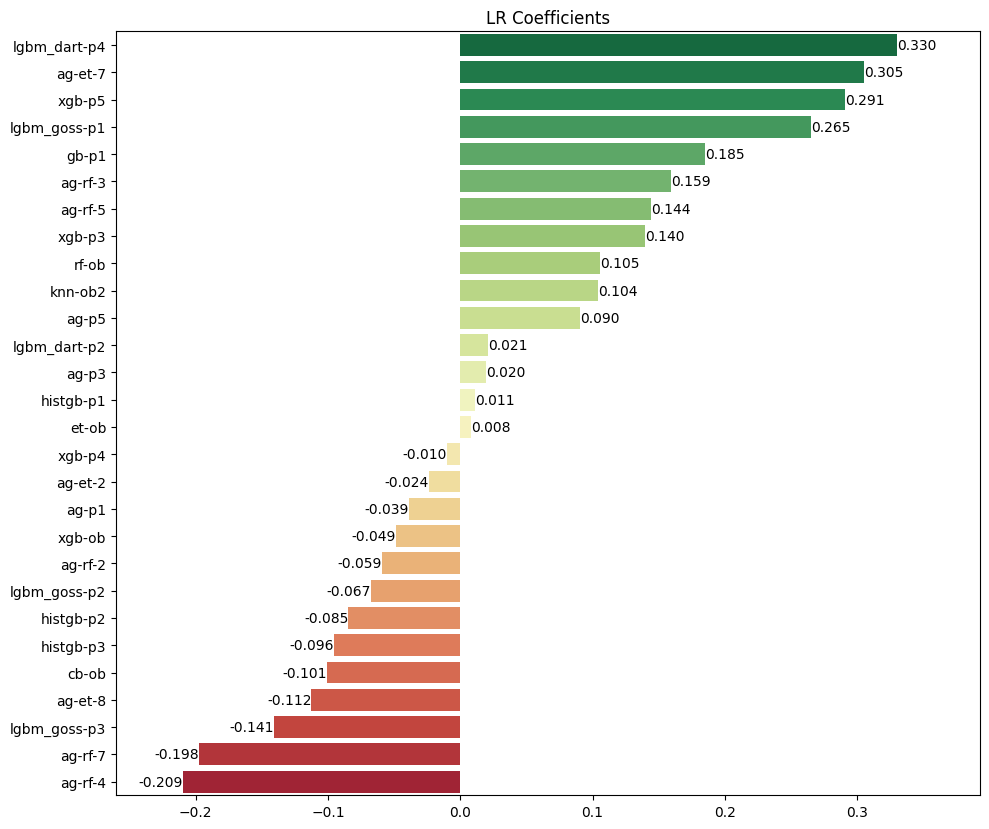

In [16]:
plot_weights(lr_coeffs, 'LR Coefficients')

In [17]:
save_submission('l2-ensemble-lr', l2_test_pred_probs['l2-ensemble-lr'], np.mean(scores['l2-ensemble-lr']))

,id,loan_status
0,58645,0.997996
1,58646,0.017143
2,58647,0.554627
3,58648,0.005459
4,58649,0.021346


# Ridge

In [18]:
ridge_feats = [
    'xgb-p4', 'lgbm_goss-p3', 'et-ob', 'cb-ob', 'ag-p3', 'rf-ob', 
    'ag-rf-3', 'xgb-ob', 'lgbm_goss-p2', 'histgb-p2', 'lgbm_goss-p1', 
    'knn-ob2', 'lgbm-ob', 'nn-2', 'lgbm-p4', 'cb-p1', 
    'lgbm_dart-ob', 'cb-ob2', 'gb-p3'
]

X = pd.DataFrame(oof_pred_probs)[ridge_feats]
X_test = pd.DataFrame(test_pred_probs)[ridge_feats]

In [19]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 0, 100),
        'tol': trial.suggest_float('tol', 1e-10, 1e-2)
    }
    
    model = Ridge(**params)
    trainer = Trainer(model)
    return trainer.fit(X, y)

if CFG.tune:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(objective, n_trials=100, n_jobs=-1)
    ridge_params = study.best_params
else:
    ridge_params = {
        "random_state": 42
    }

In [20]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42
}


In [21]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model)
l2_oof_pred_probs['l2-ensemble-ridge'], l2_test_pred_probs['l2-ensemble-ridge'], scores['l2-ensemble-ridge'], ridge_coeffs = ridge_trainer.fit_predict(X, y, X_test)

Training Ridge

--- Fold 1 - AUC: 0.967203
--- Fold 2 - AUC: 0.965441
--- Fold 3 - AUC: 0.975229
--- Fold 4 - AUC: 0.971686
--- Fold 5 - AUC: 0.969708
--- Fold 6 - AUC: 0.969158
--- Fold 7 - AUC: 0.972147
--- Fold 8 - AUC: 0.973137
--- Fold 9 - AUC: 0.970787
--- Fold 10 - AUC: 0.968330

------ Overall: 0.970222 | Average: 0.970283 ± 0.002769


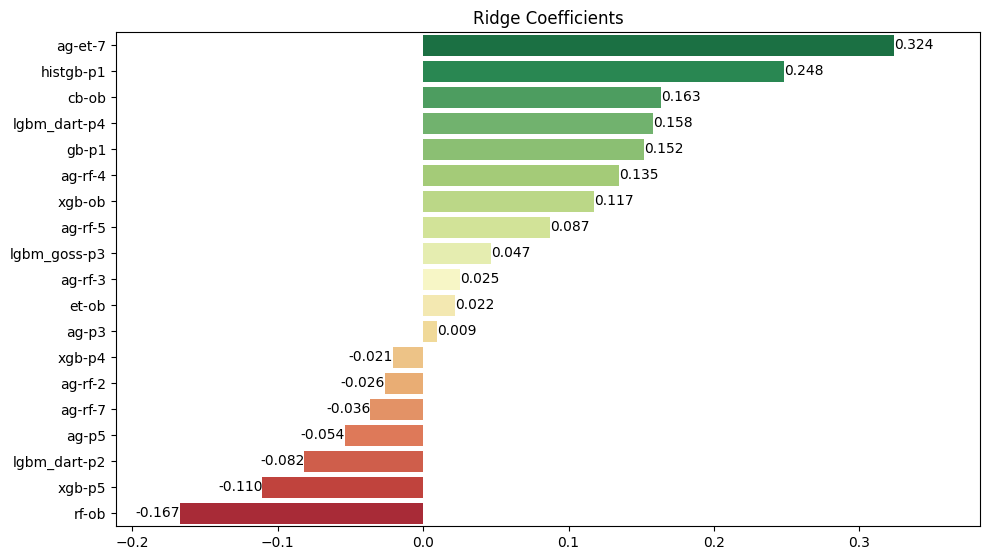

In [22]:
plot_weights(ridge_coeffs, 'Ridge Coefficients')

In [23]:
save_submission('l2-ensemble-ridge', l2_test_pred_probs['l2-ensemble-ridge'], np.mean(scores['l2-ensemble-ridge']))

,id,loan_status
0,58645,0.983292
1,58646,0.016491
2,58647,0.494919
3,58648,0.002706
4,58649,0.023830


# L3 ensemble

In [24]:
def objective(trial):
    weights = np.array([trial.suggest_float(l2_model_name, 0, 1) for l2_model_name in l2_oof_pred_probs.keys()])
    weights /= np.sum(weights)
    
    cv_scores = []
    skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for train_index, val_index in skf.split(X, y):
        preds = np.zeros(len(val_index))
        for model, weight in zip(l2_oof_pred_probs.keys(), weights):
            preds += l2_oof_pred_probs[model][val_index] * weight
            
        fold_score = roc_auc_score(y[val_index], preds)
        cv_scores.append(fold_score)
        
    return np.mean(cv_scores)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000, n_jobs=-1)

[I 2024-11-01 10:33:52,652] A new study created in memory with name: no-name-e3b7c616-b0ab-4908-a892-af5bfe439fe8
[I 2024-11-01 10:33:52,965] Trial 0 finished with value: 0.9705354460634078 and parameters: {'l2-ensemble-lr': 0.28133807637853925, 'l2-ensemble-ridge': 0.47016083104256867}. Best is trial 0 with value: 0.9705354460634078.
[I 2024-11-01 10:33:53,000] Trial 2 finished with value: 0.9703346382957513 and parameters: {'l2-ensemble-lr': 0.038944672037156014, 'l2-ensemble-ridge': 0.6825370187574331}. Best is trial 0 with value: 0.9705354460634078.
[I 2024-11-01 10:33:53,012] Trial 3 finished with value: 0.9705641654991803 and parameters: {'l2-ensemble-lr': 0.6321130430043521, 'l2-ensemble-ridge': 0.5949454055866786}. Best is trial 3 with value: 0.9705641654991803.
[I 2024-11-01 10:33:53,025] Trial 1 finished with value: 0.9704540674338713 and parameters: {'l2-ensemble-lr': 0.6676406504517957, 'l2-ensemble-ridge': 0.1259496334791934}. Best is trial 3 with value: 0.9705641654991803

In [25]:
scores['l3-weighted-ensemble'] = [study.best_value] * CFG.n_folds

In [26]:
best_weights = study.best_params
best_weights = [best_weights[l2_model] for l2_model in l2_oof_pred_probs.keys()]
best_weights /= np.sum(best_weights)
print(best_weights)

[0.56404499 0.43595501]


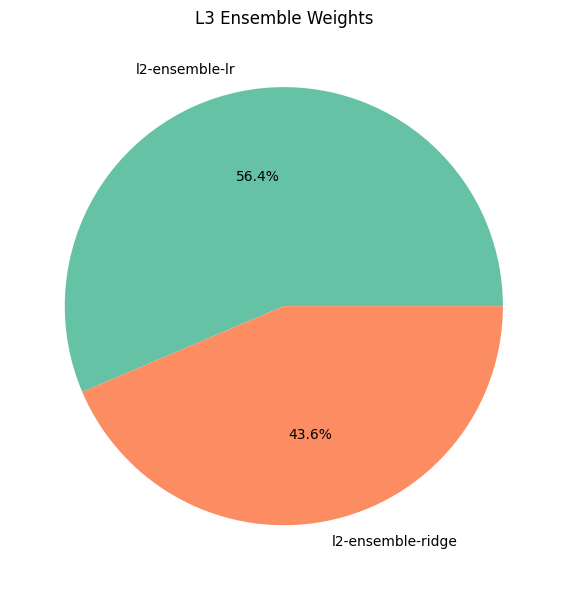

In [27]:
plt.figure(figsize=(10, 6))
plt.pie(study.best_params.values(), labels=study.best_params.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', 2))
plt.title("L3 Ensemble Weights")
plt.tight_layout()
plt.show()

In [28]:
weighted_test_preds = np.zeros((X_test.shape[0]))
for model, weight in zip(l2_test_pred_probs.keys(), best_weights):
    weighted_test_preds += l2_test_pred_probs[model] * weight
    
save_submission('l3-weighted-ensemble', weighted_test_preds, np.mean(scores['l3-weighted-ensemble']))

,id,loan_status
0,58645,0.991586
1,58646,0.016859
2,58647,0.528597
3,58648,0.004259
4,58649,0.022429


# Results

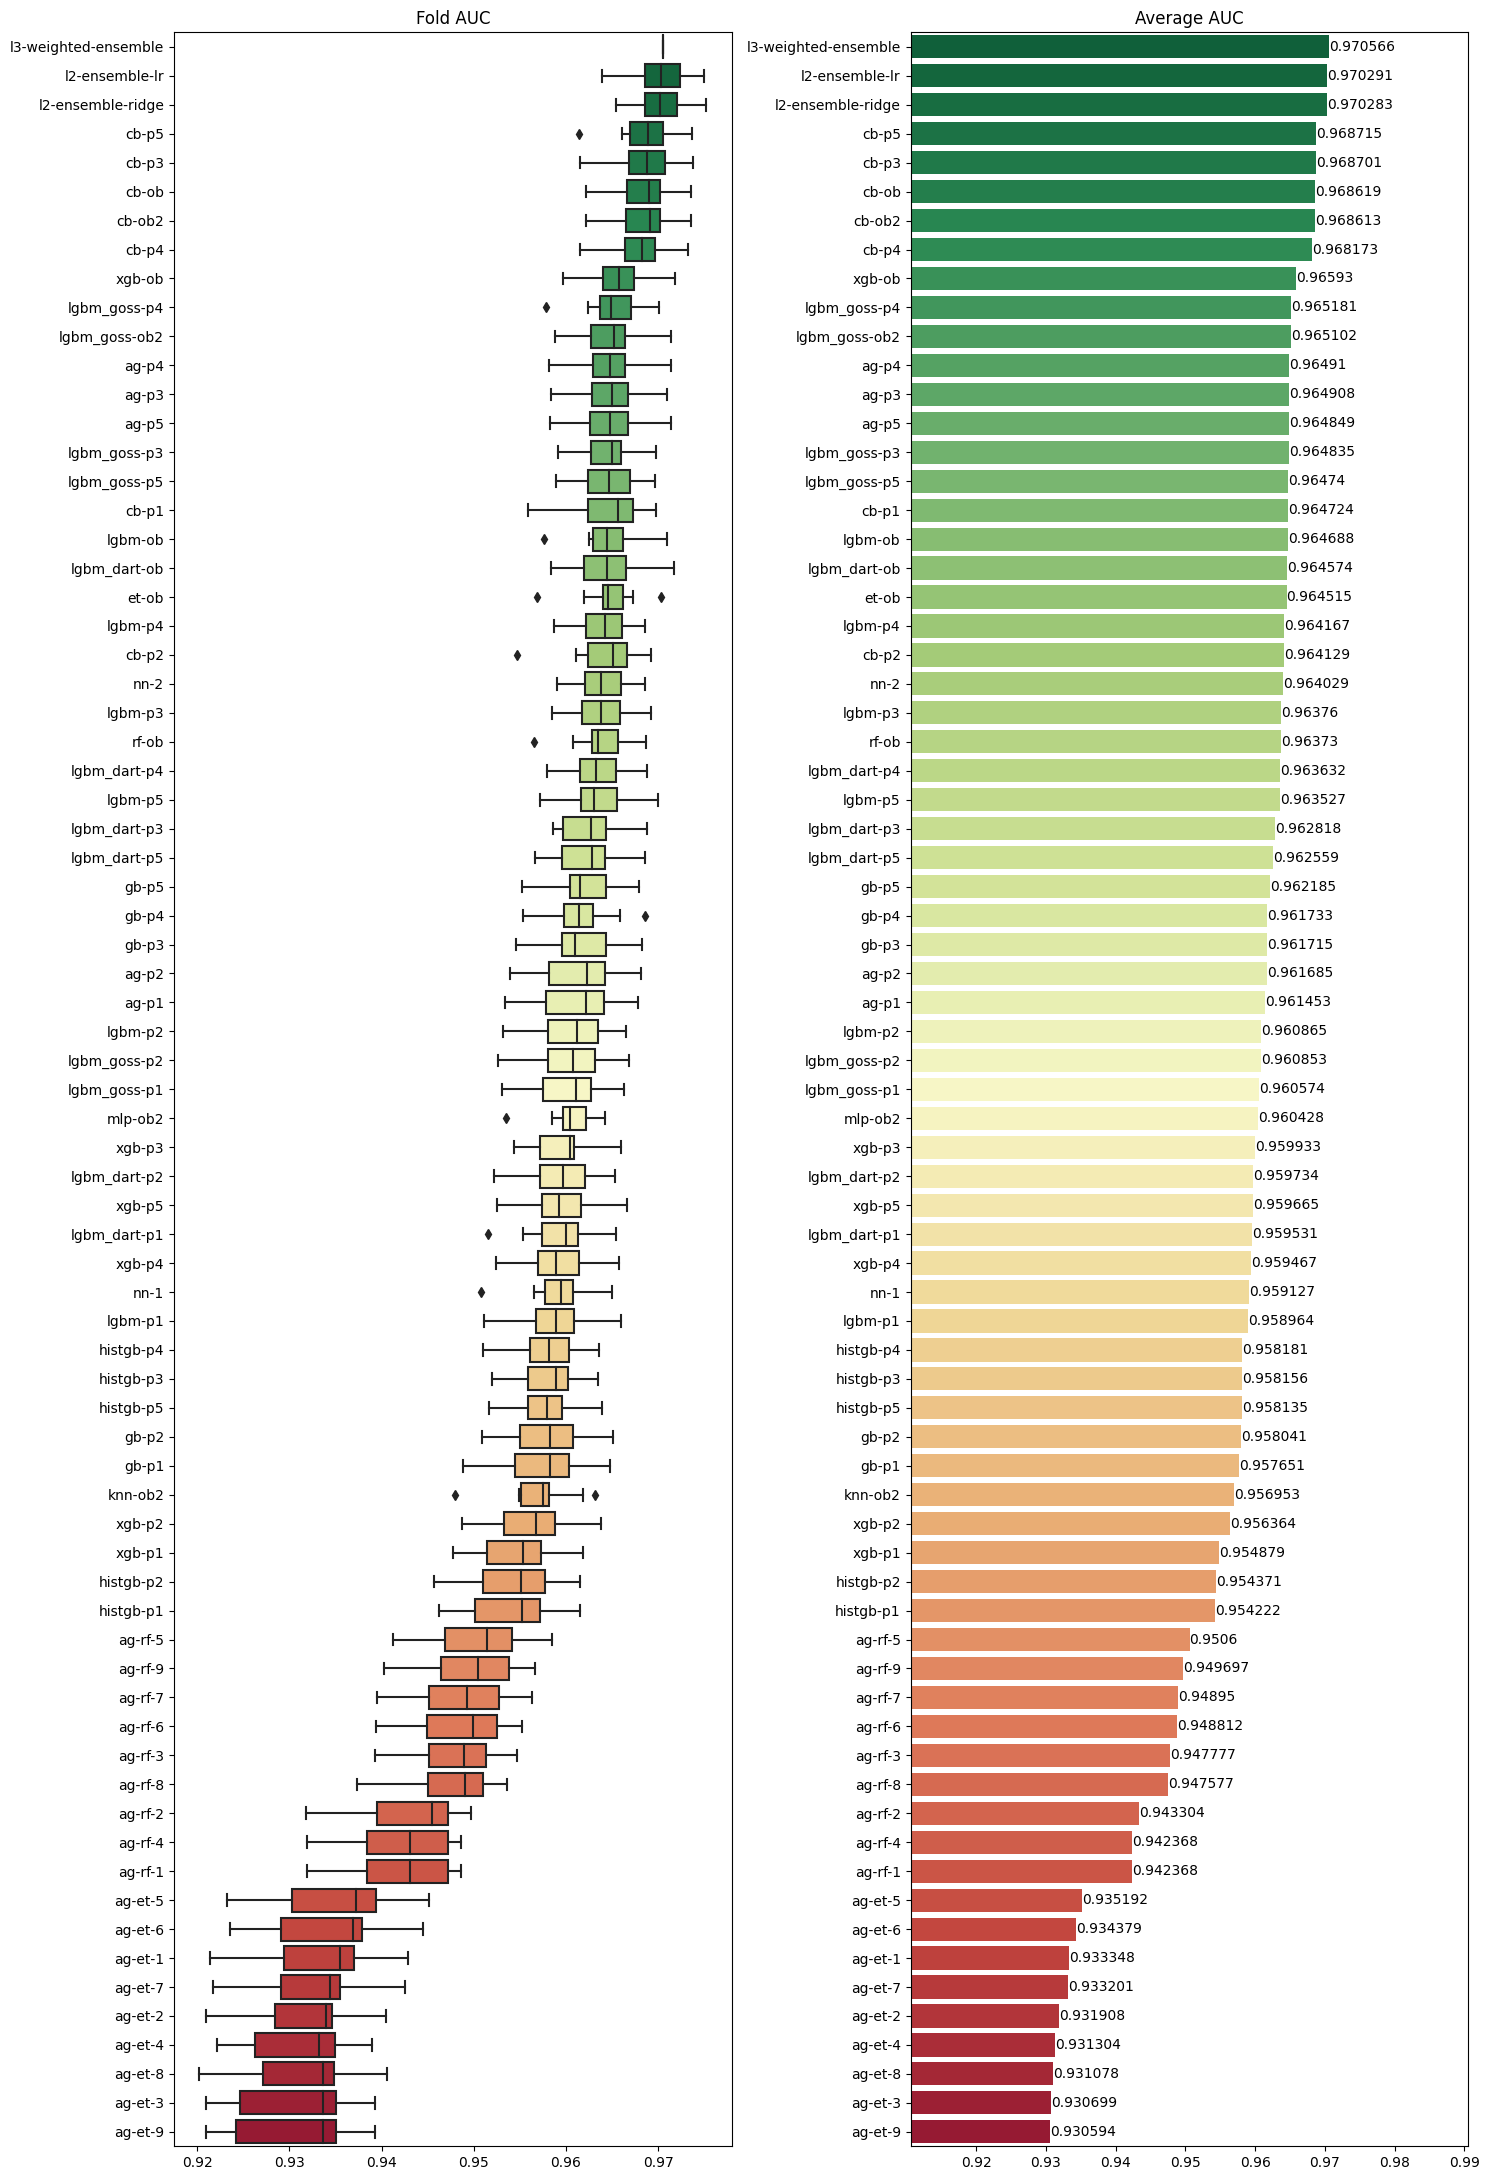

In [29]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()